## TRAINING IMPLEMENTATION 

In this notebook: 
- training script to be run on GPU

## 1. Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
import scipy
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial
import math
import csv
import time
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
from SSN_classes_jax_jit import SSN2DTopoV1_ONOFF_local
from SSN_classes_jax_on_only import SSN2DTopoV1
config.update('jax_debug_nans', True)
from util import GaborFilter, BW_Grating, find_A, create_gratings, create_data

from analysis import findRmax, plot_losses, plot_results_two_layers, param_ratios_two_layer, plot_sigmoid_outputs

jax backend cpu


->Check GPU available

## 2. PARAMETERS TO DEFINE

### 2.1 Stimuli parameters

In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 4

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

class conn_pars_m():
    PERIODIC = False
    p_local = None
    J_2x2 = None
    w_sig = None
    b_sig = None
    
class conn_pars_s():
    PERIODIC = False
    p_local = None
    J_2x2 = None
    s_2x2 = None
    sigma_oris = None
    w_sig = None
    b_sig = None
        
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 10000
    verbose = False
    silent = True
    Rmax_E = None
    Rmax_I= None

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1.5
    lambda_b = 1

In [3]:
def take_log(J_2x2):
    
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    return logJ_2x2

def init_set_func(init_set, conn_pars,  middle = False):
    #ORIGINAL TRAINING!!
    if init_set ==4:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 1,1
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]
        

    if init_set ==0:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 0.57328625, 0.26144141
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]

    if init_set ==1:
        Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
        gE, gI = 0.37328625, 0.26144141
        sigEE, sigIE = 0.2, 0.40
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.4, 0.7]

    if init_set==2:
        Js0 = [1.72881688, 1.29887564, 1.48514091, 0.76417991]
        gE, gI = 0.5821754, 0.22660373
        sigEE, sigIE = 0.225, 0.242
        sigEI, sigII = .09, .09
        conn_pars.p_local = [0.0, 0.0]
    
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
    J_2x2 = make_J2x2(*Js0)
    s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])
    sigma_oris = (np.asarray([1000.0, 1000.0]))
    
    #Middle layer only has J_2x2 parameters
    if middle:
        conn_pars.p_local = [1, 1]
    
    return J_2x2, s_2x2, gE, gI, sigma_oris, conn_pars

In [4]:
init_set =1
J_2x2_s, s_2x2_s, gE, gI, sigma_oris_s, conn_pars_s  = init_set_func(init_set, conn_pars_s)
J_2x2_m, _, gE_m, gI_m, _, conn_pars_m  = init_set_func(init_set, conn_pars_m, middle = True)

#J_2x2_m_init = [4.3160706, 1.7048993, 5.172759, 1.2093563]
#J_2x2_s_init = [4.3810773, 1.5625902, 4.9504952, 1.3793736]
#s_2x2s_init = [0.22362085, 0.089999996, 0.39480424,  0.089999996]

#make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]])
#make_s2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, Jei], [Jie,  Jii]])

#J_2x2_s = make_J2x2(*J_2x2_s_init)
#J_2x2_m = make_J2x2(*J_2x2_m_init)
#s_2x2_s = make_s2x2(*s_2x2s_init)

logJ_2x2_s =take_log(J_2x2_s)
logs_2x2_s = np.log(s_2x2_s)

logJ_2x2_m =take_log(J_2x2_m)


#sigma_oris_s = np.log(np.asarray([1000.0, 1000.0]))

#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.086948
c_I = 5.0129266

#Sigmoid parameters
N_neurons = 25


w_sig = np.asarray([ 1.65255964e-02, -2.02851743e-02,  1.47125358e-03,  4.32006381e-02,
  2.59337798e-02, -4.07500396e-04,  2.88240220e-02,  1.46174524e-03,
 -1.32988971e-02, -3.61239421e-03,  6.57914279e-05, -1.17886653e-02,
 -6.87494315e-03,  1.67297688e-03, -2.15619290e-03, -3.67136369e-03,
 -5.64075832e-04,  3.58234299e-03, -1.59664568e-03,  1.00693129e-01,
 -8.73062983e-02, -1.87561601e-01,  1.21363625e-01,  2.78673577e-03,
  1.95321068e-03])

b_sig = -0.0024999115


### 2.3 Training params

In [5]:
#Number of epochs
epochs = 100
num_epochs_to_save =21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)
epochs_to_save = np.insert(epochs_to_save, 0, 0)
noise_type = 'multiplicative'
model_type = 1

eta=10e-4
sig_noise = 2.5
batch_size = 50

In [7]:
#Name of results csv
home_dir = os.getcwd()

#Create directory for results
results_dir = os.path.join(home_dir, 'results', '20-03')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
results_name = 'two_layer_jit.csv'   
#results_name = 'set_'+str(init_set)+'_model_type_'+str(model_type)+'noise_2_mult_offset_'+str(offset)+'.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)
print(results_filename)

/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/20-03/two_layer_jit.csv



## 3. TRAINING!

In [8]:
def save_params_dict(opt_pars, true_acc, ber_acc, epoch ):
    save_params = {}
    save_params= dict(epoch = epoch, val_accuracy= true_acc, 
                      ber_accuracy = ber_acc)
    
    for key in opt_pars.keys():
        
        if key =='logJ_2x2':
            J_2x2 = sep_exponentiate(opt_pars['logJ_2x2'][0])
            Jm = dict(J_EE_m= J_2x2[0,0], J_EI_m = J_2x2[0,1], 
                              J_IE_m = J_2x2[1,0], J_II_m = J_2x2[1,1])
            
            J_2x2 = sep_exponentiate(opt_pars['logJ_2x2'][1])
            Js = dict(J_EE_s= J_2x2[0,0], J_EI_s = J_2x2[0,1], 
                              J_IE_s = J_2x2[1,0], J_II_s = J_2x2[1,1])
            
            save_params.update(Jm)
            save_params.update(Js)
        
        elif key =='logs_2x2':
            s_2x2 = np.exp(opt_pars['logs_2x2'])
            
            ss = dict(s_EE_s= s_2x2[0,0], s_EI_s = s_2x2[0,1], 
                              s_IE_s = s_2x2[1,0], s_II_s = s_2x2[1,1])
        
           
            save_params.update(ss)
        
        elif key=='sigma_oris':
            if len(opt_pars['sigma_oris']) ==1:
                save_params[key] = opt_pars[key]
            else:
                sigma_oris = dict(sigma_orisE = np.exp(opt_pars['sigma_oris'][0]), sigma_orisI = np.exp(opt_pars['sigma_oris'][1]))
                save_params.update(sigma_oris)
        
        elif key =='w_sig':
            save_params[key] = opt_pars[key]
            norm_w = np.linalg.norm(opt_pars[key])
            save_params['norm_w'] = norm_w
        
        else:
                save_params[key] = opt_pars[key]

    
    return save_params


def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])

    
    return J_2x2, s_2x2


def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def constant_to_vec(c_E, c_I, sup = False):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_I, vec_E, vec_I))
    
    if sup:
        constant_vec = np.hstack((vec_E, vec_I))
        
    return constant_vec

def our_max(x, beta=0.5):
    #nscipy function
    #max_val = scipy.special.logsumexp(x*beta)/beta
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val


def sigmoid(x, epsilon = 0.001):
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon


def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def obtain_fixed_point(ssn, ssn_input, conv_pars):
    
    r_init = np.zeros(ssn_input.shape[0])
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)

    avg_dx = np.maximum(0, (avg_dx -1))
    
    return fp, avg_dx


def middle_layer_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100, inhibition = False):
    
    fp, avg_dx = obtain_fixed_point(ssn, ssn_input, conv_pars)
    
    #Add responses from E and I neurons
    fp_E_on = ssn.select_type(fp, select='E_ON').ravel()
    fp_E_off = ssn.select_type(fp, select='E_OFF').ravel()
    
    layer_output = fp_E_on + fp_E_off
    
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))

    return layer_output, r_max, avg_dx
    

def obtain_fixed_point_centre_E(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100, inhibition = False):
    
    #Obtain fixed point
    fp, avg_dx = obtain_fixed_point(ssn, ssn_input, conv_pars)
    
    #Apply bounding box to data
    r_box = (ssn.apply_bounding_box(fp, size=3.2)).ravel()
    
    #Obtain inhibitory response 
    if inhibition ==True:
        r_box_i = ssn.apply_bounding_box(fp, size=3.2, select='I_ON').ravel()
        r_box = [r_box, r_box_i]
    
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return r_box, r_max, avg_dx


def take_log(J_2x2):
    
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    return logJ_2x2


def sep_exponentiate(J_s):
    signs=np.array([[1, -1], [1, -1]]) 
    new_J =np.exp(J_s)*signs

    return new_J

def create_param_1(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_s):
    '''
    Training: logJ_2x2, log_s2x2, w_sig, b_sig, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars_s.sigma_oris = sigma_oris

    return opt_pars, conn_pars_s

def create_param_2(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training:logJ_2x2, sigma_oris, w_sig, b_sig, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, sigma_oris = sigma_oris, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.s_2x2 = logs_2x2

    return opt_pars, conn_pars

def create_param_3(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training:logJ_2x2, w_sig, b_sig, c_E, c_I
    '''
    opt_pars = dict(logJ_2x2 = logJ_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris
    conn_pars.s_2x2 = logs_2x2
    
    return opt_pars, conn_pars
    

def create_param_4(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training: w_sig, b_sig
    '''
    conn_pars.J_2x2 = logJ_2x2
    conn_pars.s_2x2 = logs_2x2
    conn_pars.sigma_oris = sigma_oris
    conn_pars.c_E = c_E
    conn_pars.c_I = c_I
    
    opt_pars = dict(w_sig = w_sig, b_sig = b_sig)

    return opt_pars, conn_pars


def create_param_5(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    '''
    Training: logJ_2x2, log_s2x2, c_E, c_I
    '''
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris
    conn_pars.w_sig = w_sig
    conn_pars.b_sig = b_sig
    
    return opt_pars, conn_pars

def separate_param_1(opt_pars, conn_pars_s):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = opt_pars['logs_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    
    sigma_oris = conn_pars_s.sigma_oris
   
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

def separate_param_2(opt_pars, conn_pars):
    
    logJ_2x2 = opt_pars['logJ_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    sigma_oris=opt_pars['sigma_oris']
    log_s2x2 = conn_pars.s_2x2
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris


def separate_param_3(opt_pars, conn_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = conn_pars.s_2x2
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    sigma_oris = conn_pars.sigma_oris
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris


def separate_param_4(opt_pars, conn_pars):
    log_J_2x2 = conn_pars.J_2x2
    log_s_2x2 = conn_pars.s_2x2
    sigma_oris = conn_pars.sigma_oris
    c_E = conn_pars.c_E
    c_I = conn_pars.c_I
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

def separate_param_5(opt_pars, conn_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = opt_pars['logs_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    
    w_sig = conn_pars.w_sig
    b_sig = conn_pars.b_sig
    sigma_oris = conn_pars.sigma_oris
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris

@partial(jax.jit, static_argnums=(0, 1, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20), device = jax.devices()[0])
def new_model(ssn_mid, ssn_sup, logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, train_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type='no_noise'):

    
    J_2x2_m = sep_exponentiate(logJ_2x2[0])
    J_2x2_s = sep_exponentiate(logJ_2x2[1])
    s_2x2_s = np.exp(logs_2x2)
    sigma_oris_s = np.exp(sigma_oris)
    fE, fI = 1,1
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(c_E, c_I)
    constant_vector_sup = constant_to_vec(c_E, c_I, sup=True)
    
    #Create W matrix
    ssn_mid.make_local_W(J_2x2_m)
    ssn_sup.make_W(J_2x2_s, s_2x2_s, sigma_oris_s)
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn_mid.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn_mid.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find fixed point for middle layer
    r_ref_mid, r_max_ref_mid, avg_dx_ref_mid = middle_layer_fixed_point(ssn_mid, SSN_input_ref, conv_pars)
    r_target_mid, r_max_target_mid, avg_dx_target_mid = middle_layer_fixed_point(ssn_mid, SSN_input_target, conv_pars)
    
    #Input to superficial layer
    sup_input_ref = np.hstack([r_ref_mid*fE, r_ref_mid*fI]) + constant_vector_sup
    sup_input_target = np.hstack([r_target_mid*fE, r_target_mid*fI]) + constant_vector_sup
    
    #Find fixed point for superficial layer
    r_ref, r_max_ref_sup, avg_dx_ref_sup= obtain_fixed_point_centre_E(ssn_sup, sup_input_ref, conv_pars)
    r_target, r_max_target_sup, avg_dx_target_sup= obtain_fixed_point_centre_E(ssn_sup, sup_input_target, conv_pars)

    #Add additional noise before sigmoid layer
    if noise_type =='additive':
        r_ref =r_ref + sig_noise*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*numpy.random.normal(size=(r_target.shape))
        
    elif noise_type == 'multiplicative':
        r_ref = r_ref*(1 + sig_noise*numpy.random.normal(size=(r_ref.shape)))
        r_target = r_target*(1 + sig_noise*numpy.random.normal(size=(r_target.shape)))
         
    elif noise_type =='poisson':
        r_ref = r_ref + sig_noise*np.sqrt(r_ref)*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*np.sqrt(r_target)*numpy.random.normal(size=(r_target.shape))

    elif noise_type =='no_noise':
        pass
    
    else:
        raise Exception('Noise type must be one of: additive, mulitiplicative, poisson')
    
    delta_x = r_ref - r_target
    sig_input = np.dot(w_sig, (delta_x)) + b_sig
    
    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(w_sig, (delta_x)) + b_sig)
    
    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref_mid + avg_dx_target_mid)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref_mid + r_max_target_mid)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(w_sig)**2)
    loss_b = loss_pars.lambda_b*(b_sig**2)
    
    #Combine all losses
    loss = loss_binary + loss_w + loss_b +  loss_avg_dx + loss_r_max
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    pred_label = np.round(x) 
    
    #Calculate predicted label using Bernoulli distribution
    #key_int = numpy.random.randint(low = 0, high =  10000)
    #key = random.PRNGKey(key_int)
    #pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
    pred_label_b = np.zeros((x.shape))

   
    return loss, all_losses, pred_label, pred_label_b, sig_input, x



def loss(opt_pars, ssn_mid, ssn_sup, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type=1, evaluate=False):
    
    
    
    #Separate parameters
    if model_type==1:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_1(opt_pars, conn_pars_s)
        
    if model_type==2:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_2(opt_pars, conn_pars_m, conn_pars_s)
    
    if model_type==3:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_3(opt_pars, conn_pars_m, conn_pars_s)
    
    if model_type ==4:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_4(opt_pars, conn_pars_m, conn_pars_s)
        
    if model_type ==5:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris = separate_param_5(opt_pars, conn_pars_m, conn_pars_s)
    
    total_loss, all_losses, pred_label, pred_label_b, delta_x, x= vmap_model(ssn_mid, ssn_sup, logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)
    
    loss= np.mean(total_loss)
    all_losses = np.mean(all_losses, axis = 0)
        
    true_accuracy = np.sum(test_data['label'] == pred_label)/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_label_b)/len(test_data['label']) 
       
        
    return loss, [all_losses, true_accuracy, ber_accuracy, delta_x, x]
    

    
    
def train_SSN_vmap(J_2x2_m, J_2x2_s, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, sig_noise = None, test_size = None, noise_type='additive', model_type=1, readout_pars=None, early_stop = 0.6):
          
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    train_accs = []
    train_sig_input = []
    train_sig_output = []
    val_sig_input = []
    val_sig_output = []
    
    #Take logs of parameters
    logJ_2x2_s =take_log(J_2x2_s)
    logs_2x2 = np.log(s_2x2_s)
    logJ_2x2_m =take_log(J_2x2_m)
    logJ_2x2 = [logJ_2x2_m, logJ_2x2_s]
    
    test_size = batch_size if test_size is None else test_size
    
    #Initialise networks
    
    ssn_mid=SSN2DTopoV1_ONOFF_local(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_m, filter_pars=filter_pars, J_2x2=J_2x2_m, gE = gE, gI=gI)
    ssn_sup=SSN2DTopoV1(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_s, filter_pars=filter_pars, J_2x2=J_2x2_s, s_2x2=s_2x2_s, gE = gE, gI=gI, sigma_oris = sigma_oris_s)
    ssn_sup.input_ori_map(ssn_mid.ori_map)
    ssn_sup.create_gabor_filters()
    print(ssn_mid.ori_map)
    
    
    #Initialise vmap version of model
    vmap_model = vmap(new_model, in_axes = (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    
    #Separate parameters used in optimisation
    if model_type ==1:
        opt_pars, conn_pars_s = create_param_1(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_s)
    
    if model_type==2:
        opt_pars, conn_pars_m, conn_pars_s = create_param_2(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_m, conn_pars_s)
    
    if model_type==3:
        opt_pars, conn_pars_m, conn_pars_s = create_param_3(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_m, conn_pars_sn_pars)
    
    if model_type ==4:
        opt_pars, conn_pars_m, conn_pars_s= create_param_4(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_m, conn_pars_s)
        
    if model_type ==5:
        opt_pars, conn_pars_m, conn_pars_s = create_param_5(logJ_2x2, logs_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars_m, conn_pars_s)
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    print(opt_pars)
    
    print('Training model with learning rate {}, sig_noise {} at offset {}, lam_w {}, batch size {}, noise_type {}'.format(eta, sig_noise, offset, loss_pars.lambda_w, batch_size, noise_type))
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
    val_loss, [all_losses, true_acc, ber_acc, delta_x, x]= loss(opt_pars, ssn_mid, ssn_sup, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type, evaluate = True)
    print('Before training  -- loss: {}, true accuracy: {} , Bernoulli accuracy: {}'.format(np.round(float(val_loss), 3), np.round(true_acc, 3), np.round(ber_acc, 3)))
    val_loss_per_epoch.append(val_loss)
    train_sig_input.append(delta_x)
    val_sig_input.append(delta_x)
    train_sig_output.append(x)
    val_sig_output.append(x)

    
    #Save initial parameters
    initial_save_params = save_params_dict(opt_pars=opt_pars, true_acc=true_acc, ber_acc = ber_acc, epoch=0)
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer = csv.DictWriter(results_handle, fieldnames=initial_save_params.keys(), delimiter=',')
        results_writer.writeheader()
        results_writer.writerow(initial_save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING! ####')
    
    loss_and_grad = jax.value_and_grad(loss, has_aux = True)
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #Load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        [epoch_loss, [epoch_all_losses, train_true_acc, train_ber_acc, train_delta_x, train_x]], grad =loss_and_grad(opt_pars, ssn_mid, ssn_sup, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, train_data, filter_pars, conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type)
        training_losses.append(epoch_loss)
        all_losses = np.hstack((all_losses, epoch_all_losses))
        train_accs.append(train_true_acc)
        train_sig_input.append(train_delta_x)
        train_sig_output.append(train_x)
 
        epoch_time = time.time() - start_time
        
        if model_type ==4 and epoch>5 and np.mean(np.asarray(train_accs[-5:]))>early_stop:
                print('Early stop: {} accuracy achieved at epoch {}'.format(early_stop, epoch))
                break

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
            start_time = time.time()
            val_loss, [val_all_losses, true_acc, ber_acc, val_delta_x, val_x ]= loss(opt_pars, ssn_mid, ssn_sup, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type, evaluate = True)
            val_time = time.time() - start_time
            print('Training loss: {} ¦ Validation -- loss: {}, true accuracy: {}, Bernoulli accuracy: {} at epoch {}, (time {}, {})'.format(epoch_loss, val_loss, true_acc, ber_acc, epoch, epoch_time, val_time))
            val_loss_per_epoch.append(val_loss)
            val_sig_input.append(val_delta_x)
            val_sig_output.append(val_x)
                
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
    
        #Save new optimized parameters
        if epoch in epochs_to_save:
            if results_filename:
                save_params = save_params_dict(opt_pars=opt_pars, true_acc=true_acc, ber_acc=ber_acc, epoch=epoch)
                results_writer.writerow(save_params)
    
    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])
    #if 'logJ_2x2' in opt_pars.keys():
    #    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    #if 'logs_2x2' in opt_pars.keys():
    #    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    if 'sigma_oris' in opt_pars.keys():
        opt_pars['sigma_oris'] = np.exp(opt_pars['sigma_oris'])
   
    return opt_pars, val_loss_per_epoch, all_losses, train_accs, train_sig_input, train_sig_output, val_sig_input, val_sig_output



In [9]:
new_opt_pars, val_loss_per_epoch, training_losses, training_accs, train_sig_input, train_sig_output, val_sig_input, val_sig_output= train_SSN_vmap(J_2x2_m, J_2x2_s, s_2x2_s, sigma_oris_s, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = None, batch_size=batch_size, ref_ori = ref_ori, offset = offset, epochs=epochs, eta=eta, sig_noise = sig_noise, noise_type=noise_type, model_type=model_type)

[[ 80.84741  118.275475  58.222897  76.60089  101.05036  140.59648
   71.70907  114.96561  164.24709 ]
 [ 54.86649  123.83768  135.99756   27.861303 102.41838   88.85773
  156.31999  130.75284  149.87085 ]
 [ 79.905014  42.641888 113.25367   71.095535 125.170784  68.936874
  147.55812  117.653694 170.9148  ]
 [121.630585 143.68239  139.69272   65.28     158.2295    59.624653
  100.688194  75.16939  166.87234 ]
 [ 91.297195 101.36862  168.48268   37.070847 153.29688  142.58534
  170.18488  169.7246   159.96307 ]
 [ 14.172124  90.771965 129.67758  142.7895    43.32506   79.09537
   54.744198 139.53712  159.23582 ]
 [ 39.23394   45.596725  59.648876  68.92113   61.18207   97.5979
   97.63669  111.68151   44.530495]
 [ 83.75496   91.517235  83.56067  143.40459   55.076694  62.875282
   43.9686     8.716059  23.564747]
 [ 52.937527 106.05302  111.48718  115.282295  70.24783  113.11106
  115.70603  135.71153    6.294053]]
{'logJ_2x2': [DeviceArray([[1.4909518 , 0.5057398 ],
             [1.6

KeyboardInterrupt: 

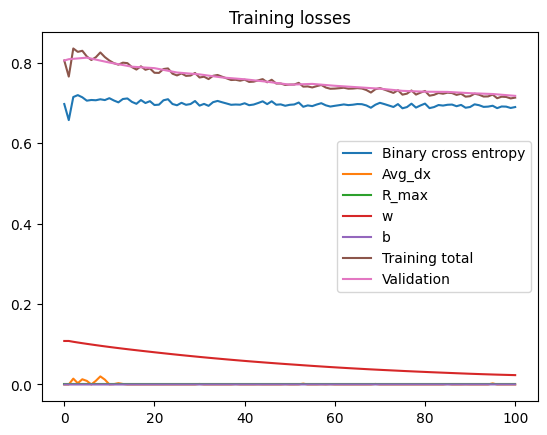

In [22]:
losses_dir = os.path.join(results_dir, 'two_layer_run')
#losses_dit = os.path.join(results_dir,'two_layer_losses')
plot_losses(training_losses, val_loss_per_epoch, epochs_to_save, save = losses_dir)

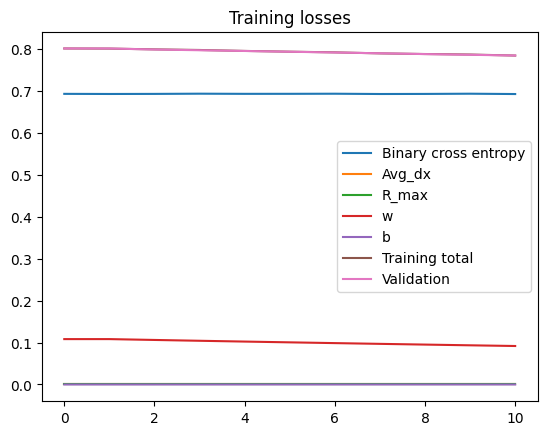

In [26]:
#np.save(os.path.join(results_dir, 'training_losses.npy'), training_losses)
#np.save(os.path.join(results_dir, 'validation_losses.npy'), val_loss_per_epoch)

losses_dir = os.path.join(results_dir, 'testing_new_network')
#losses_dit = os.path.join(results_dir,'two_layer_losses')
plot_losses(training_losses, val_loss_per_epoch, epochs_to_save, save = losses_dir)

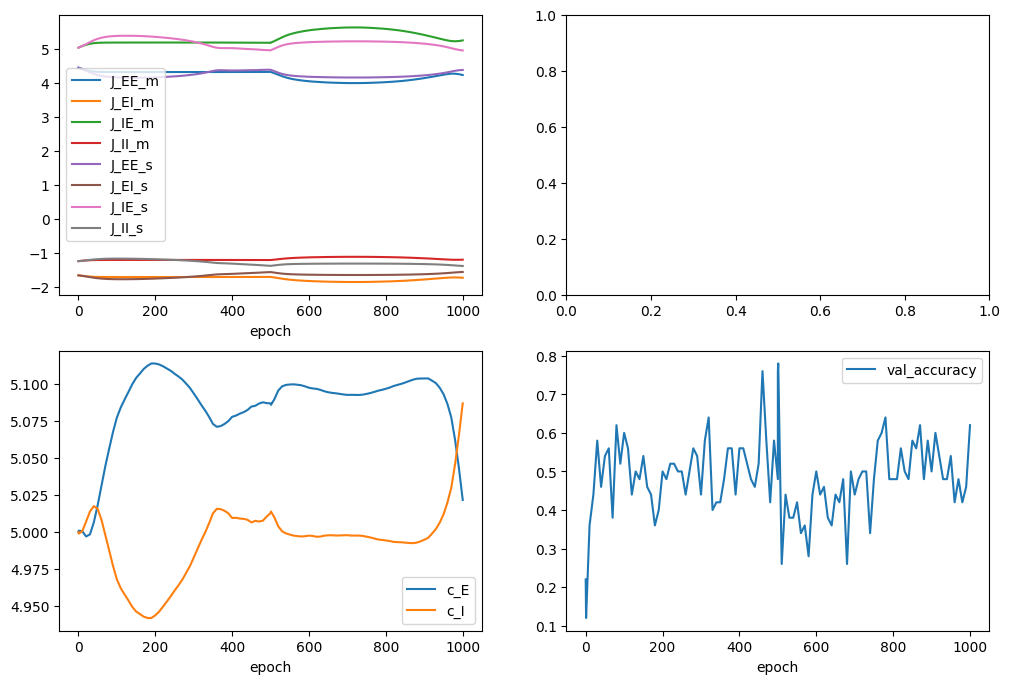

In [9]:
#results_plot_dir = os.path.join(results_dir, 'two_layer_combined')
#results_plot_dir = os.path.join(results_dir, 'mult_results_set_'+str(init_set)+'_model_type_'+str(model_type)+'offset_'+str(offset) )
plot_results_two_layers(all_results, norm_w=False, bernoulli=False)#, save=results_plot_dir)

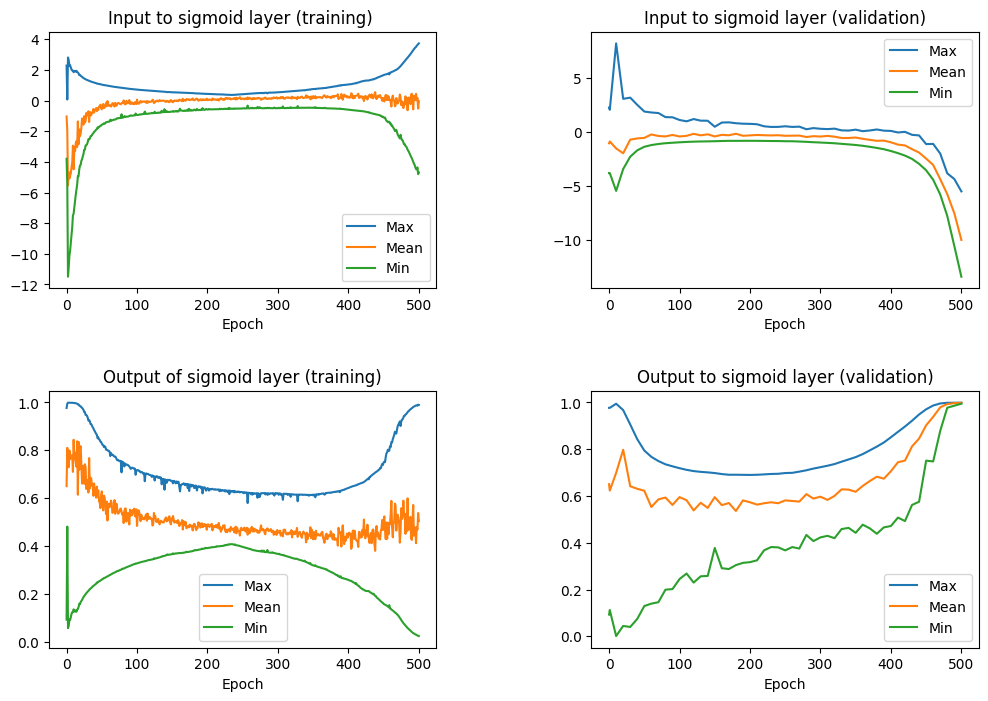

In [42]:
sigmoid_plots = os.path.join(results_dir, 'sigmoid_two_layer')
plot_sigmoid_outputs(train_sig_input, val_sig_input, train_sig_output, val_sig_output, epochs_to_save, save = sigmoid_plots)

In [59]:
def vmap_eval_hist(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type):

    vmap_model = vmap(new_model, in_axes = (None, None, None, None, None, None, None, None, None, None, None, None, None, {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    losses, all_losses, pred_label, pred_label_b = vmap_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)

    #Find accuracy based on predicted labels
    true_accuracy = np.sum(test_data['label'] == pred_label)/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_label_b)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    all_losses = np.mean(all_losses, axis = 0)
    
    return vmap_loss, all_losses, true_accuracy, ber_accuracy
                    
                    
def vmap_eval3(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars, conv_pars, loss_pars, sig_noise, noise_type):
    '''
    Iterates through all values of 'w' to give the losses at each stimuli and weight, and the accuracy at each weight
    Output:
        losses: size(n_weights, n_stimuli )
        accuracy: size( n_weights)
    '''
    eval_vmap = vmap(vmap_eval_hist, in_axes = (None, None, None, None, 0, None, None, None, None, None, None, None, None, {'ref':None, 'target':None, 'label':None}, None, None, None, None, None) )
    losses, _,  true_acc, ber_acc = eval_vmap(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)

    return losses, true_acc, ber_acc
                    
def test_accuracies(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, filter_pars, conv_pars, stimuli_pars, loss_pars, offset, sig_noise, noise_type, trials = 5, p = 0.9, printing=True):
    
    key = random.PRNGKey(7)
    N_neurons = 25
    accuracies = []
    key, _ = random.split(key)
    w_sig= random.normal(key, shape = (trials, N_neurons)) / np.sqrt(N_neurons)
    
    train_data = create_data(stimuli_pars, offset = offset)
    val_loss, true_acc, ber_acc = vmap_eval3(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, train_data, filter_pars, conv_pars, loss_pars, sig_noise, noise_type)
    
    #calcualate how many accuracies are above 90
    higher_90 = np.sum(true_acc[true_acc>p]) / len(true_acc)
    
    if printing:
        print('grating contrast = {}, jitter = {}, noise std={}, acc (% >90 ) = {}'.format(stimuli_pars['grating_contrast'], stimuli_pars['jitter_val'], stimuli_pars['std'], higher_90))
    print(true_acc.shape)
    
    return higher_90, true_acc, w_sig


def initial_acc( logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, filter_pars,  conv_pars, stimuli_pars,  loss_pars,  offset, noise_type, min_sig_noise , max_sig_noise, min_jitter = 3, max_jitter = 5, p = 0.9, len_noise=11, len_jitters=3):
    '''
    Find initial accuracy for varying jitter and noise levels. 
    
    '''

    print(noise_type)
    list_noise  =  np.logspace(start=np.log10(min_sig_noise), stop=np.log10(max_sig_noise), num=len_noise, endpoint=True, base=10.0, dtype=None, axis=0)
    list_jitters = np.linspace(min_jitter, max_jitter, len_jitters)
   
    
    low_acc=[]
    all_accuracies=[]
    percent_50=[]
    good_w_s=[]
    
    
    for sig_noise in list_noise:
        for jitter in list_jitters:
            
            #stimuli_pars['std'] = noise
            stimuli_pars['jitter_val'] = jitter
            higher_90, acc, w_s = test_accuracies(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE, gI, filter_pars, conv_pars, stimuli_pars, loss_pars, offset, sig_noise, noise_type, p=p,  trials=100, printing=False)
            print(acc.shape)
            #save low accuracies
            if higher_90 < 0.05:
                low_acc.append([jitter, sig_noise, higher_90])
            
            
            indices = list(filter(lambda x: acc[x] == 0.5, range(len(acc))))
            w_s = [w_s[idx] for idx in indices]
            good_w_s.append(w_s)
            
            all_accuracies.append([jitter, sig_noise, acc])
            
    plot_histograms(all_accuracies)
        
    
    return all_accuracies, low_acc, percent_50, good_w_s


def plot_histograms(all_accuracies):
    
    n_rows =  int(np.sqrt(len(all_accuracies)))
    n_cols = int(np.ceil(len(all_accuracies) / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    count = 0

    
   #plot histograms
    for k in range(n_rows):
        for j in range (n_cols):
            axs[k,j].hist(all_accuracies[count][2])
            axs[k,j].set_xlabel('Initial accuracy')
            axs[k,j].set_ylabel('Frequency')
            axs[k,j].set_title('noise = '+str(np.round(all_accuracies[count][1], 2))+ ' jitter = '+str(np.round(all_accuracies[count][0], 2)), fontsize=10)
            count+=1
            if count==len(all_accuracies):
                break
    
    fig.show()
    
    
def accuracies(all_acc, p = 0.75):
    '''
    Print accuracies and jitters that give an accuracy between 0.45-0.55 for initialisation
    '''
    
    acc_to_save = []
    for x in range(len(all_acc)):
        acc = all_acc[x][2]
        if ((0.45 < acc) & (acc < 0.55)).sum() /len(acc)>p:
            print(all_acc[x][0], all_acc[x][1])
            acc_to_save.append([all_acc[x][0], all_acc[x][1]])
        
    return acc_to_save

multiplicative
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


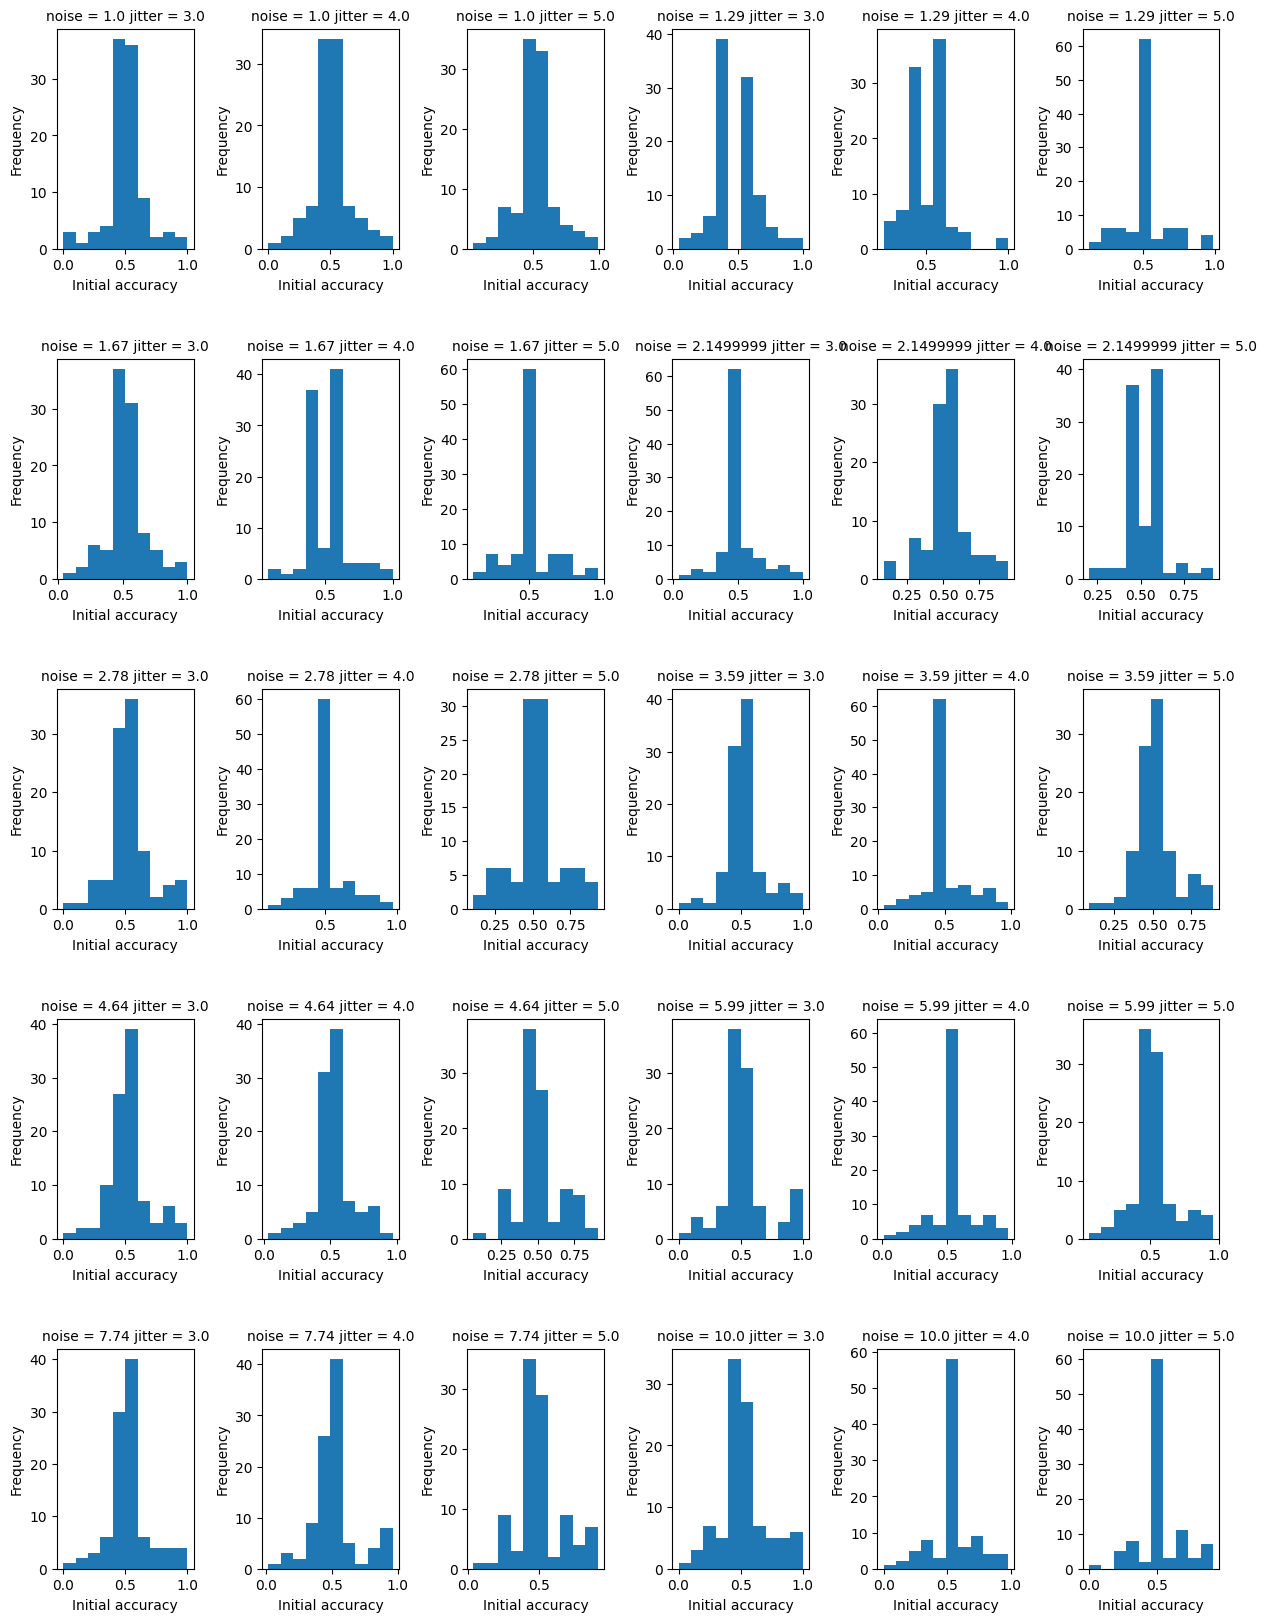

In [67]:
all_acc, low_acc, percent_50, w = initial_acc( logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, sigma_oris, ssn_pars, grid_pars, conn_pars_m, conn_pars_s, gE_s, gI_s, filter_pars,  conv_pars, stimuli_pars,  loss_pars, offset, noise_type, min_sig_noise =1 , max_sig_noise =10, len_noise = 10)

In [69]:
accuracies(all_acc, p=0.6)

3.0 1.0
4.0 1.0
5.0 1.0
5.0 1.2915497
5.0 1.6681005
3.0 2.1544347
3.0 2.7825592
4.0 2.7825592
3.0 3.5938134
3.0 4.641588
3.0 5.994842
4.0 5.994842
3.0 7.7426357


[[DeviceArray(3., dtype=float32), DeviceArray(1., dtype=float32)],
 [DeviceArray(4., dtype=float32), DeviceArray(1., dtype=float32)],
 [DeviceArray(5., dtype=float32), DeviceArray(1., dtype=float32)],
 [DeviceArray(5., dtype=float32), DeviceArray(1.2915497, dtype=float32)],
 [DeviceArray(5., dtype=float32), DeviceArray(1.6681005, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(2.1544347, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(2.7825592, dtype=float32)],
 [DeviceArray(4., dtype=float32), DeviceArray(2.7825592, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(3.5938134, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(4.641588, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(5.994842, dtype=float32)],
 [DeviceArray(4., dtype=float32), DeviceArray(5.994842, dtype=float32)],
 [DeviceArray(3., dtype=float32), DeviceArray(7.7426357, dtype=float32)]]

Testing two layer network rates

In [79]:
J_2x2_s

DeviceArray([[ 4.4413204, -1.6582118],
             [ 5.0289063, -1.2416493]], dtype=float32)

In [47]:
init_set =1
J_2x2_s, s_2x2_s, gE_s, gI_s, sigma_oris_s, conn_pars_s  = init_set_func(init_set, conn_pars_s)
J_2x2_m, _, gE_m, gI_m, _, conn_pars_m  = init_set_func(init_set, conn_pars_m, middle = True)

fE, fI = 1,1

conn_pars_m = conn_pars[0]
conn_pars_s = conn_pars[1]

#Create vector using extrasynaptic constants
constant_vector = constant_to_vec(c_E, c_I)

#Initialise networks
ssn_mid=SSN2DTopoV1_ONOFF_local(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_m, filter_pars=filter_pars, J_2x2=J_2x2_m, gE=gE_m, gI=gI_m)
ssn_sup=SSN2DTopoV1_AMPAGABA(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_s, filter_pars=filter_pars, J_2x2=J_2x2_s, s_2x2=s_2x2_s, gE=gE_s, gI=gI_s, sigma_oris=sigma_oris_s)
c_s = np.linspace(0, 100, 21)
c_s = c_s.at[0].set(1)


all_rates_mid = []
all_rates_sup = []

In [48]:
for c in c_s:
    
    c_vec = np.ones((ssn_mid.gabor_filters.shape[0], )) * c
    c_vec_sup = np.ones((ssn_sup.gabor_filters.shape[0], )) * c
    
    
    #test_data = create_data(stimuli_pars, number = 1, offset = offset, ref_ori = ref_ori)
    #stimuli = test_data['ref'][0]
    
    #constant_vector = constant_to_vec(c_E, c_I)
    
    #output_ref=np.matmul(ssn_mid.gabor_filters, stimuli) + constant_vector
    #SSN_input_ref=np.maximum(0, output_ref)

    
    fp_mid, avg_dx_mid = obtain_fixed_point(ssn_mid, c_vec, conv_pars)
    
    fp_E_on = ssn_mid.select_type(fp_mid, select='E_ON').ravel()
    fp_E_off = ssn_mid.select_type(fp_mid, select='E_OFF').ravel()
    
    layer_output = fp_E_on + fp_E_off
    sup_input_ref = np.hstack([layer_output*fE, layer_output*fI])
    
    all_rates_mid.append(np.unique(fp_mid))

    fp_sup, avg_dx_sp = obtain_fixed_point(ssn_sup, c_vec_sup, conv_pars)

    all_rates_sup.append(np.unique(fp_sup))
    


In [ ]:
#all_rates_mid = np.asarray([np.unique(np.round(item, 3)) for item in all_rates_mid])
#all_rates_sup = [np.unique(np.round(item, 2)) for item in all_rates_sup]

all_rates_mid = np.asarray([item.max() for item in all_rates_mid])
all_rates_sup = np.asarray([item.max() for item in all_rates_sup])

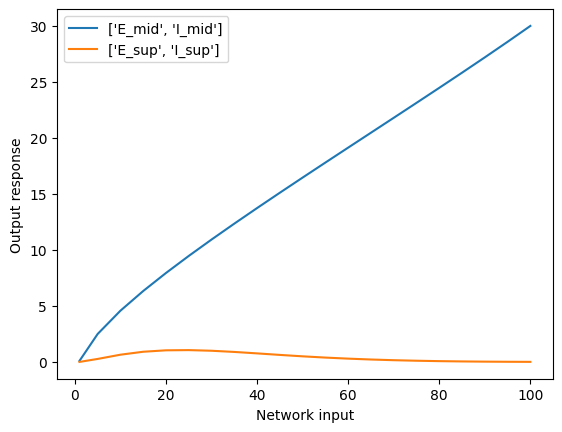

In [41]:
plt.plot(c_s, all_rates_mid, label = ['E_mid', 'I_mid'])
plt.plot(c_s, all_rates_sup, label = ['E_sup', 'I_sup'])
plt.xlabel('Network input')
plt.ylabel('Output response')
plt.legend()
plt.show()

In [70]:
all_rates_mid

DeviceArray([[ 0.072     ,  0.09      ],
             [ 0.90500003,  2.4980001 ],
             [ 1.199     ,  4.5750003 ],
             [ 1.3230001 ,  6.333     ],
             [ 1.3740001 ,  7.9430003 ],
             [ 1.381     ,  9.464001  ],
             [ 1.3590001 , 10.927     ],
             [ 1.3160001 , 12.349001  ],
             [ 1.258     , 13.740001  ],
             [ 1.1880001 , 15.108001  ],
             [ 1.11      , 16.461     ],
             [ 1.0250001 , 17.802     ],
             [ 0.934     , 19.136002  ],
             [ 0.84000003, 20.467001  ],
             [ 0.74300003, 21.798     ],
             [ 0.646     , 23.132002  ],
             [ 0.54800004, 24.474     ],
             [ 0.45200002, 25.827002  ],
             [ 0.35900003, 27.196001  ],
             [ 0.27      , 28.585001  ],
             [ 0.18800001, 30.003002  ]], dtype=float32)